Funnet saker.csv med 11675 rader, sist lagret 2025-04-20 16:20


1) Bruk lagrede saker 2) Hent nye saker (1/2):  2


Henter data fra 2025-04-07 til 2099-12-31
Hentet side 1, saker totalt: 1000
Hentet side 2, saker totalt: 2000
Hentet side 3, saker totalt: 3000
Hentet side 4, saker totalt: 4000
Hentet side 5, saker totalt: 5000
Hentet side 6, saker totalt: 6000
Hentet side 7, saker totalt: 7000
Hentet side 8, saker totalt: 8000
Hentet side 9, saker totalt: 9000
Hentet side 10, saker totalt: 10000
Hentet side 11, saker totalt: 11000
Hentet side 12, saker totalt: 11669
Lagret 11669 saker til saker.csv
Filtrér mellom 2025-04-06 og 2026-03-24. Dersom du trykker enter/retur, vil du beholde laveste 
dato og høyeste dato i datasettet.


Fra-dato [2025-04-06]:  
Til-dato [2026-03-24]:  


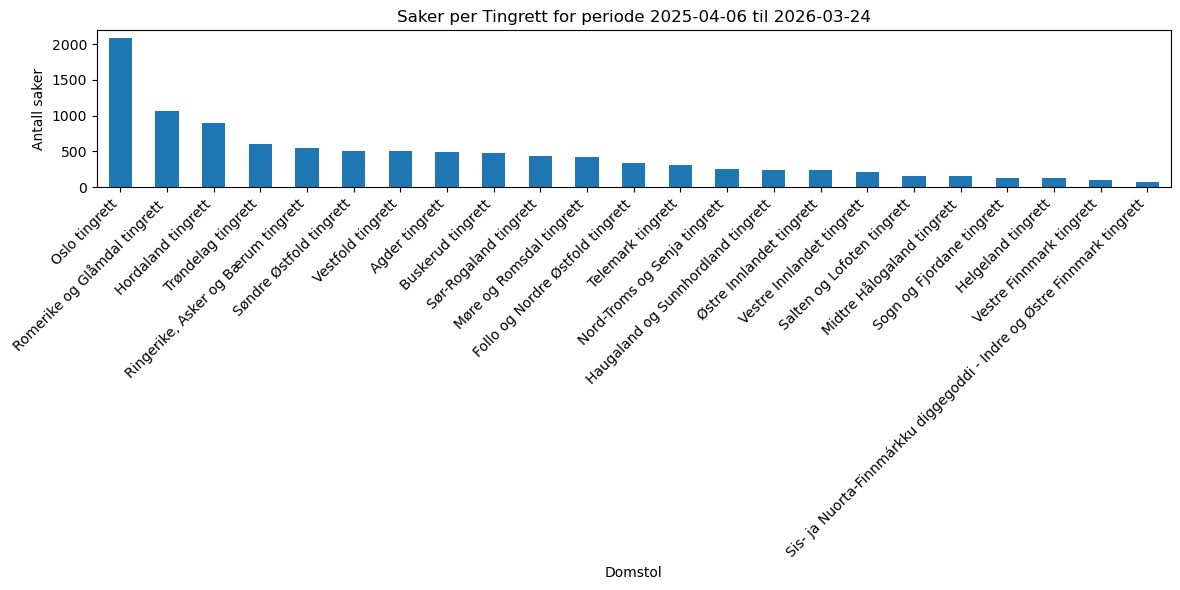

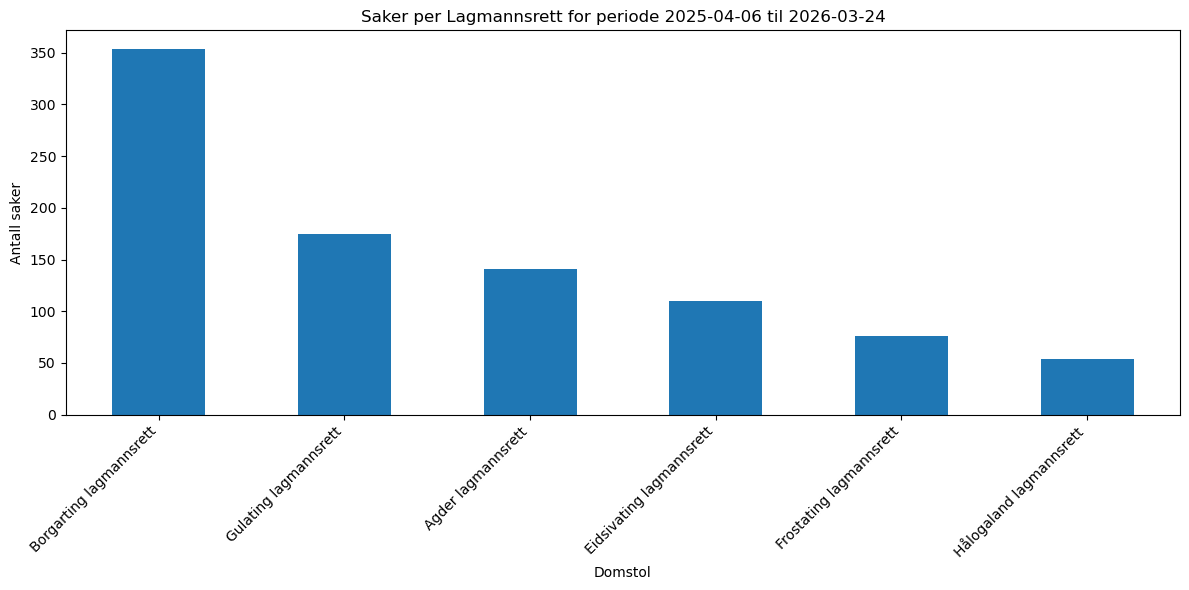

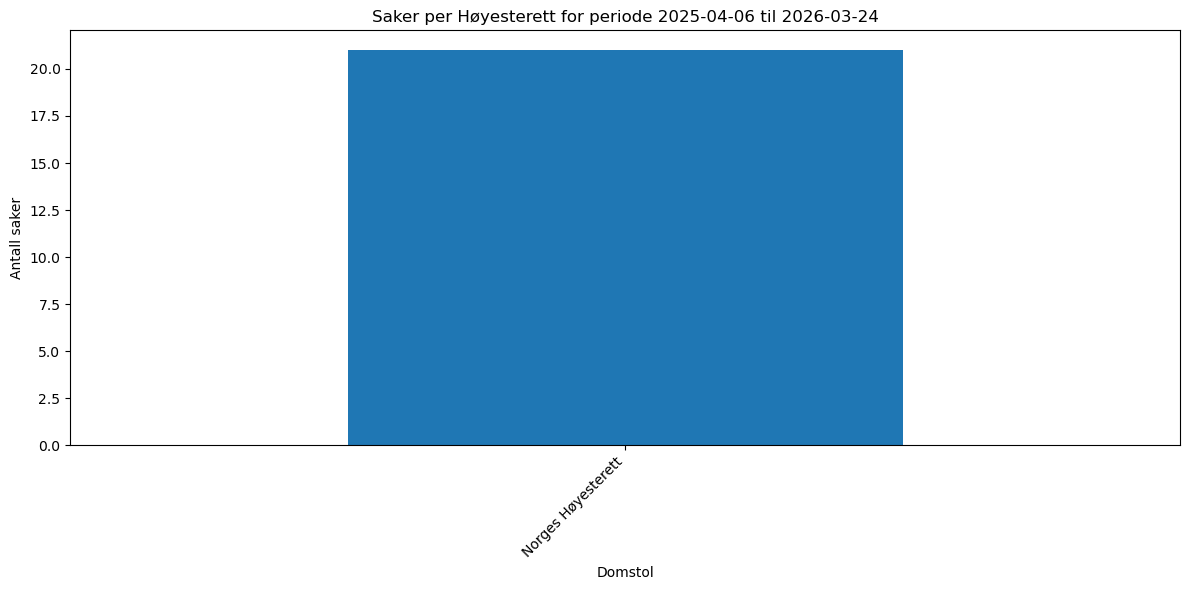

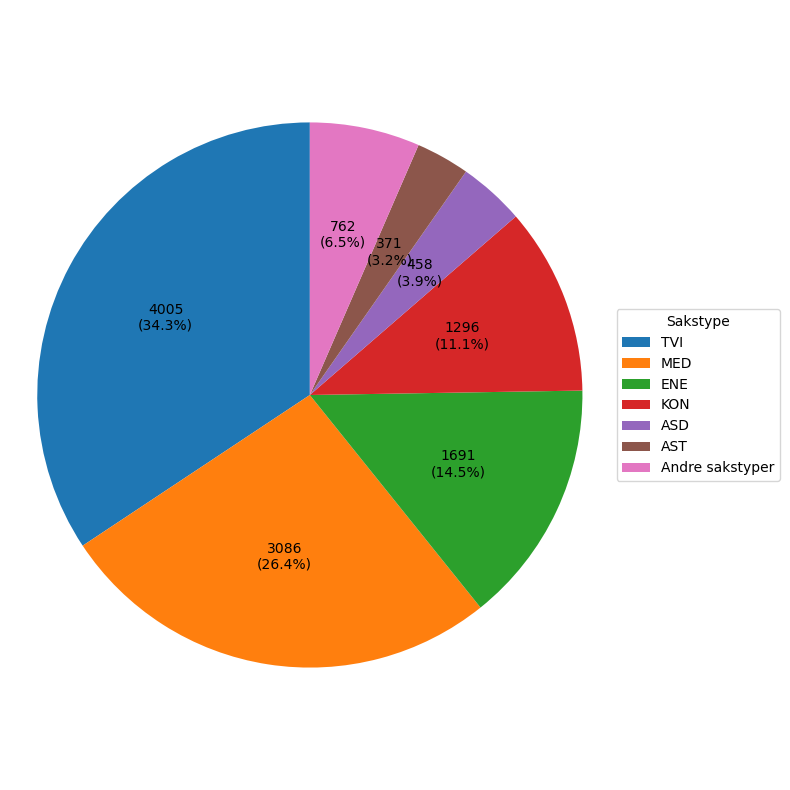


Forklaringer for sakstyper:
  TVI: Tvistesaker
  MED: Meddommersaker
  ENE: Enedommersaker
  KON: Konkurssaker
  ASD: Ankesak, dom
  AST: Andre ankesaker
  RFA: Rettsfastsettende sak
  REN: Rettsendrende sak
  SKJ: Skjønnssak
  GJE: Gjeldsordning
  DBO: Skiftesak
  Annet: Andre sakstyper
  SAM: Samlivssak
  TVA: Tvangssaker
  SIV-HRET: Sivil sak, Høyesterett
  STR-HRET: Straffesak, Høyesterett
  ASK: Ankesak, kjennelse


In [148]:
"""
 Prosjektoppgave PY1010

 Skrevet av Daniel Dale Laabak
 Vår 2025

 Programmet henter data om berammede rettssaker i rettssystemet i Norge og gir en oversikt over
 de sakene som er berammet i samtlige tingretter, lagmannsretter og høyesterett  i datointervallet brukeren velger.

 Da det alltid er en fare for at API på nettsidene til domstol kan endre seg, er en fallback-løsning
 å hente dataene fra en lagret fil som har korrekt format, saker.csv . Denne filen følger også prosjekt-
 oppgaven, og programmet faller tilbake på denne filen dersom web-api ikke er mulig å hente fra. 

 Domstolene har en bra åpen oversikt over berammede saker, men sier ingenting om antall saker av en
 viss type, eller antall saker som er til behandling ved de ulike domstolene. Som journalist eller som 
 interessert i saker som er til behandling i rettsvesenet vil dette kunne gi en god oversikt over sakene
 som til enhver tid er til behandling i retssystemet. 

 Domstolene har ikke noe offisielt API. APIet er funnet ved å besøke nettsiden til domstol.no, og inspisere
 hva nettleseren faktisk gjør når man søker på berammede saker i domstolene. En slik løsning innebærer derfor
 alltid risiko for at noe kan endre seg.

 BESKRIVELSE AV RETUR FRA API:
APIet gir svar i json-format, og svaret ser slik ut (eksempel):

EKSEMPEL START
{
  "FormData": {
    "From": "2025-04-19T00:00:00",
    "To": "2099-04-19T00:00:00",
    "Periode": "",
    "Court": "",
    "CourtName": "Alle domstoler",
    "CourtValue": "",
    "AdvancedSearch": false,
    "CaseAbout": "",
    "CaseNumber": "",
    "Page": 1,
    "PageSize": 1000,
    "sortAscending": true,
    "sortTerm": "startdato"
  },
  "hits": [
    {
      "id": "164514",
      "embeteId": "AAAA2103101754092672012RXHZEG_EJBOrgUnit",
      "startdato": "2025-04-19T08:00:00",
      "sluttdato": "2025-04-19T08:50:00",
      "domstol": "Søndre Østfold tingrett",
      "saksnummer": "25-063575ENE-TSOS/TSAR",
      "sakenGjelder": "førstegangsfengsling",
      "parter": null
    }
  ]
}
EKSEMPEL SLUTT


Videre avleder vi sakstype fra saksnummeret, da feltet "sakenGjelder" ovenfor er et fritekstfelt, og inneholder
veldig mange ulike verdier. For dette programmet har vi valgt å bare inkludere sakstypene som følger mønsteret nedenfor:
"ENE-", "TVI-", "TVA-", "MED-", "KON-", "ASD-", "AST-", "STR-HRET", "SIV-HRET", "ASK-", "DBO-", "GJE-", "REN-", "RFA-", "SAM-", "SKJ-".

En egen forklaring om hva de ulike sakstypene omfatter, fremkommer i slutten av programmet når programmet kjøres.
"""

# Først importerer vi nødvendige biblioteker for å kjøre programmet:
import os #for å lese filer
import requests #for å kunne hente data fra domstol.no
import csv #for å lese og skrive filer
from datetime import datetime,timedelta #for å håndtere datoer og å trekke fra/legge til dager
import pandas as pd #for å lage dataframes
import matplotlib.pyplot as plt #for å lage plott og diagrammer

"""
EGEN BOLK FOR FUNKSJONER OG FASTE VARIABLER
"""
# Vi starter så programmet med å angi såkalt "base"-URL for å hente inn sakene fra APIet til domstol.no:
BASE_URL = "https://www.domstol.no/api/episerver/v3/beramming"

# Vi angir så navnet på CSV-filen. Det følger en standard-fil med prosjektet. Brukeren kan velge mellom å bruke filen 
# som allerede finnes, eller om brukeren vil laste nye data og overskrive filen.
CSV_FILENAME = "saker.csv"

# Vi setter variabelen valg til None, slik at det ikke er gjort noe valg på forhånd, og slik at variabelen finnes.
# Dette gjør at variabelen er initialisert når vi skal sjekke verdien senere i koden.
valg = None

# Fordi APIet ikke gir sakstyper, har jeg laget en oversikt som en liste, som viser de ulike sakstypene APIet 
# kan returnere. Sakstypene baserer seg på en del av saksnummeret, normalt karakter 10,11 og 12 i saksnummeret. 
# Unntaket fra hovedregelen er saker for Norges Høyesterett, vi har derfor med karakterene 13-17 fra saksnummeret for 
# sakene som gjelder Norges Høyesterett.
explanations = {
            "ENE-": "Enedommersaker",
            "TVI-": "Tvistesaker",
            "TVA-": "Tvangssaker",
            "MED-": "Meddommersaker",
            "ASD-": "Ankesak, dom",
            "AST-": "Andre ankesaker",
            "KON-": "Konkurssaker",
            "STR-HRET": "Straffesak, Høyesterett",
            "SIV-HRET": "Sivil sak, Høyesterett",
            "ASK-": "Ankesak, kjennelse",
            "DBO-": "Skiftesak",
            "GJE-": "Gjeldsordning",
            "REN-": "Rettsendrende sak",
            "RFA-": "Rettsfastsettende sak",
            "SAM-": "Samlivssak",
            "SKJ-": "Skjønnssak",
            "Annet": "Andre sakstyper"
            
        }




# Vi bygger så funksjonen for å hente første side fra domstol.no sitt API, med parametere.
# Input til funksjonen er fra-dato, til-dato, sidenummer, antall treff pr. side
# Fra- og til dato settes automatisk til 14 dager før dagens dato, og frem til 2099 for å hente samtlige saker.
def fetch_page(from_date: str, to_date: str, page: int, page_size: int = 1000):

    params = {
        "fraDato": from_date,
        "tilDato": to_date,
        "page": page,
        "pageSize": page_size,
        "sortTerm": "startdato",
        "sortAscending": "true",
    }
    resp = requests.get(BASE_URL, params=params)
    resp.raise_for_status()
    data = resp.json()
    return data.get("hits", [])

# Deretter bygger vi funksjonen for å løpe gjennom alle sidene i APIet for å hente resten av sakene fra APIet
def fetch_all_cases(from_date: str, to_date: str):
    all_cases = []
    page = 1
    while True:
        hits = fetch_page(from_date, to_date, page)
        if not hits:
            break
        all_cases.extend(hits)
        print(f"Hentet side {page}, saker totalt: {len(all_cases)}")
        page += 1
    return all_cases

# Deretter bygger vi funksjonen for å lagre alle sakene til CSV, slik at vi har dataene i en fil, og senere 
# kan gjenbruke dataene fra filen, og unngå å belaste APIet unødvendig. Filename er angitt som variabel tidligere i
# programmet.
def save_to_csv(cases: list, filename: str):
    if not cases:
        print(f"Ingen saker å lagre for oppgitt datointervall.")
        return
    keys = cases[0].keys()
    with open(filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(cases)
    print(f"Lagret {len(cases)} saker til {filename}")

# Deretter bygger vi funksjonen for å viser vi saker pr. domstol i et stolpediagram(plott), filtrert på navnet på domstolen ved å bruke mask, 
# slik at vi når vi kaller funksjonen kan angi "Tingrett", "Lagmannsrett" eller "Høysterett". Andre domstoler ville man også kunne
# angi med f.eks "Jordskifterett", men dette programmet viser bare saker for tingrettene, lagmannsrettene og høyesterett.
def plot_cases_per_court(df, court, date_from, date_to):
 
    mask = df['domstol'].str.contains(court, case=False, na=False)
    counts = df.loc[mask, 'domstol'].value_counts()

    if counts.empty:
        print(f"Ingen {court}-saker fra {date_from} til {date_to}")
        return

    ax = counts.plot(kind='bar', figsize=(12, 6))
    ax.set_xlabel('Domstol')
    ax.set_ylabel('Antall saker')
    ax.set_title(f"Saker per {court} for periode {date_from} til {date_to}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# For å vise både antall saker og antall prosent av totalen hver kategori/sakstype i kakediagrammet, lager vi en funksjon 
# som beregner hvor mange prosent det aktuelle typen utgjør av totalen.
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{count}\n({pct:.1f}%)"
    return my_autopct

# Deretter bygger vi funksjonen for å viser vi saker pr. sakstype i et kakediagram(plott), filtrert på sakstypen ved å bruke mask, 
# basert på de ulike sakstypene avledet fra sasksnummeret som er definert i variablen keywords. Saker som ikke inngår i de angitte
# Sakstypene, filtreres ut og klassifiseres som "Annet". Som input har vi en minimum-prosent for å gjøre kakediagrammet mer oversiktlig
# hvor vi putter alle typer som utgjør mindre enn 2,5% (0.025) av totalen i en kategori som vi kaller "Andre sakstyper". Til slutt 
# Skriver vi ut en forklaring for hva de ulike sakstypene er.
def plot_cases_sakstyper(df, min_pct=0.025):
    df = df.copy()
    keywords = ["ENE-", "TVI-", "TVA-", "MED-", "KON-", "ASD-", "AST-",
                "STR-HRET", "SIV-HRET", "ASK-", "DBO-", "GJE-",
                "REN-", "RFA-", "SAM-", "SKJ-"]

    def hent_sakstype(s):
        s = str(s).upper()
        for kw in keywords:
            if kw in s:
                return kw.rstrip('-')
        return 'Annet'

    df['sakstype'] = df['saksnummer'].apply(hent_sakstype)

    counts = df['sakstype'].value_counts()
    total = counts.sum()

    mask = (counts / total) >= min_pct
    counts_large = counts[mask].copy()
    others_sum = counts[~mask].sum()
    if others_sum > 0:
        counts_large['Andre sakstyper'] = others_sum

    fig, ax = plt.subplots(figsize=(8, 8))
    counts_large.plot(
        kind='pie', ax=ax, labels=None,
        autopct=make_autopct(counts_large),
        startangle=90, labeldistance=1.1
    )
    ax.set_ylabel('')
    ax.axis('equal')
    ax.legend(
        counts_large.index, title="Sakstype",
        loc='center left', bbox_to_anchor=(1.0, 0.5)
    )
    plt.tight_layout()
    plt.show()

    #Skriv ut forklaringer for hver av sakstypene (med og uten - fordi strukturen er ulik).
    print("\nForklaringer for sakstyper:")
    for kode in counts.index:
        if kode in explanations:
            tekst = explanations[kode]
        else:
            tekst = explanations.get(kode + '-', "Ingen forklaring tilgjengelig")
        print(f"  {kode}: {tekst}")

"""
SLUTT PÅ FUNKSJONER OG FASTE VARIABLER
"""


""" 
START PÅ KJØRINGEN AV PROGRAMMET
"""
# Først sjekker programmet om filen finnes. Den leses inn hvis den finnes, den sjekker antall rader i filen
# og når filen sist ble lagret. Brukeren blir presentert med et valg om å bruke data fra filen eller å hente 
# inn nye data. Dersom filen ikke finnes, blir brukeren tatt videre til neste steg - valg 2 som er å hente nye
# data inn til saker.csv. 

# Leser inn filen hvis den finnes, vis antall og når den ble lagret
if os.path.exists(CSV_FILENAME):
    df_saved = pd.read_csv(CSV_FILENAME, parse_dates=['startdato'], dayfirst=False)
    n_saved = len(df_saved)
    saved_time = datetime.fromtimestamp(os.path.getmtime(CSV_FILENAME))
    print(f"Funnet {CSV_FILENAME} med {n_saved} rader, sist lagret {saved_time:%Y-%m-%d %H:%M}")
    valg = input("1) Bruk lagrede saker 2) Hent nye saker (1/2): ")

# Hvis filen ikke finnes, settes valg til 2, og brukeren får beskjed om at nye data hentes inn.
else:
    print("Det finnes ingen lokalt lagret fil, vi henter derfor nye data fra Domstol.no sitt API.")
    valg = '2'

while valg not in ('1','2'):
    valg = input("Du angav ugyldig valg. Du må velge 1 eller 2!\nVelg på nytt: \n1) Bruk lagrede saker 2) Hent nye saker (1/2): ")


# Hvis brukeren velger 1 - altså å bruke eksisterende fil, gis brukeren mulighet til å filtrere søket på egne
# valgte datoer fra CSV-filen, basert på laveste (min_date) startdato og høyeste (max_date) sluttdato i csv-filen.
if valg == '1':
    # La bruker filtrere på datoer innenfor eksisterende fil
    min_date = df_saved['startdato'].dt.date.min()
    max_date = df_saved['startdato'].dt.date.max()
    print(f"Filtrér mellom {min_date} og {max_date}. Dersom du trykker enter/retur, vil du beholde laveste \ndato og høyeste dato i datasettet.")
    inp_from = input(f"Fra-dato [{min_date}]: ").strip() or str(min_date)
    inp_to   = input(f"Til-dato [{max_date}]: ").strip() or str(max_date)

    # Sørg for at datointervall er innenfor
    d_from = max(datetime.fromisoformat(inp_from).date(), min_date)
    d_to   = min(datetime.fromisoformat(inp_to).date(),   max_date)

    print(f"Bruker lagrede saker filtrert: {d_from} til {d_to}")
    # Filtrer dataframe (df)
    df = df_saved[
        (df_saved['startdato'].dt.date >= d_from) &
        (df_saved['startdato'].dt.date <= d_to)
    ].copy()

# Hvis 2 er valgt, henter programmet automatisk samtlige saker som er tilgjengelige fra APIet. APIet tilbyr saker fra 14 dager
# tilbake i tid, og ubegrenset fremover i tid. Vi setter derfor startdatoen til 14 dager før dagens dato,
# og sluttdatoen til 2099, slik at vi henter inn samtlige saker som er tilgjengelige i APIet. 
# Dersom brukeren opererer i en annen tidssone enn oss, vil forespørselen kunne feile, ettersom APIet gir en feilmelding som
# vi velger å ikke håndtere for dette prosjektets del, dersom man forsøker å spørre mer enn 14 dager tilbake i tid.
# TODO: Lage feilhåndtering basert på tilbakemelding fra APIet. 
else:
    # Hent nye saker: standard første kjøring 14 dager tilbake i tid frem til utgangen av år 2099
    inp_from = (datetime.now() - timedelta(days=14)).strftime('%Y-%m-%d')
    inp_to   = '2099-12-31'

    #Skriv ut informasjon mens sakene hentes
    print(f"Henter data fra {inp_from} til {inp_to}")
    cases = fetch_all_cases(inp_from, inp_to)
    #Lagre sakene til CSV
    save_to_csv(cases, CSV_FILENAME)

    # Les inn CSV på nytt 
    df = pd.read_csv(CSV_FILENAME, parse_dates=['startdato'], dayfirst=False)
    
    # La bruker filtrere på datoer innenfor eksisterende csv-fil
    min_date = df['startdato'].dt.date.min()
    max_date = df['startdato'].dt.date.max()
    print(f"Filtrér mellom {min_date} og {max_date}. Dersom du trykker enter/retur, vil du beholde laveste \ndato og høyeste dato i datasettet.")
    inp_from = input(f"Fra-dato [{min_date}]: ").strip() or str(min_date)
    inp_to   = input(f"Til-dato [{max_date}]: ").strip() or str(max_date)
    d_from = datetime.fromisoformat(inp_from).date()
    d_to   = datetime.fromisoformat(inp_to).date()


#Til slutt kaller vi funksjonene med datointervaller og navn (Tingrett/Lagmannsrett/Høyesterett)
plot_cases_per_court(df, "Tingrett", d_from, d_to)
plot_cases_per_court(df, "Lagmannsrett", d_from, d_to)
plot_cases_per_court(df, "Høyesterett", d_from, d_to)
plot_cases_sakstyper(df)